# VQE for Fusion

In [15]:
import numpy as np
#from numpy.core.umath_tests import inner1d

import functools
from operator import mul
# from mpmath import *
import time
import sys
import random
import cmath
import itertools
import matplotlib.pyplot as plt

# Importing Qiskit libraries
from qiskit.algorithms.optimizers import ADAM, CG, GSLS, NELDER_MEAD, NFT, POWELL, SPSA, TNC, COBYLA, L_BFGS_B, SLSQP, AQGD, P_BFGS, GradientDescent
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info.operators.symplectic.pauli_utils import pauli_basis
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.execute_function import execute
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.opflow import I, Z, X, Y, StateFn, SummedOp, CircuitOp, CircuitStateFn
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.hamiltonians.heisenberg_model import HeisenbergModel
from qiskit_nature.second_q.hamiltonians.fermi_hubbard_model import FermiHubbardModel

from scipy.optimize import minimize, rosen, rosen_der
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

import sympy
from sympy import Matrix
from sympy.physics.quantum import TensorProduct
from sympy.physics.quantum.dagger import Dagger

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# The IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Session

%config InlineBackend.figure_format='retina'

from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition
from qiskit_nature.second_q.hamiltonians.ising_model import IsingModel

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

In [346]:
!pip install pytket pytket-qiskit pytket-quantinuum 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 224.8 kB/s eta 0:00:0000:01

[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 82.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 227.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 554.7 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: qiskit-ibm-provider
    Found existing installation: qiskit-ibm-provider 0.6.3
    Uninstalling qiskit-ibm-provider-0.6.3:
      Successfully uninstalled qiskit-ibm-provider-0.6.3
  Attempting uninstall: qiskit-ibm-runtime
    Found existing installation: qiskit-ibm-runtime 0.11.3
    Uninstalling qiskit-ibm-runtime-0.11.3:
      Successfully uninstalled qiskit-ibm-runtime-0.11.3

[notice] A new release of pip availab

In [ ]:
!pip install  

In [356]:
from pytket.extensions.qiskit.tket_backend import TketBackend
from qiskit import Aer
from qiskit.primitives import BackendEstimator
from pytket.extensions.quantinuum import QuantinuumBackend

# # simulator = Aer.get_backend('aer_simulator')
# # aer_backend = BackendEstimator(simulator, options={"shots": 500})

# machine = 'H1-2E'
# backend_emu = QuantinuumBackend(device_name=machine)
# backend_emu.login()
# qis_backend = TketBackend(backend_emu)
# qestimator = BackendEstimator(qis_backend, options={"shots": 100})

In [16]:
II = np.array([[1,0],[0,1]])
ZZ = np.array([[1,0],[0,-1]])
XX = np.array([[0,1],[1,0]])
YY = np.array([[0,-1.j],[1.j,0]])
 
# Outputs the Kroneker product of two matrices
def kroneker_product(a,b):
    
    row = a.shape[0]*b.shape[0]    # Calculates no.of rows of the product matrix 
    col = a.shape[1]*b.shape[1]    # Calculates no.of columns of the product matrix
    
    z1 = a[:,:,None] 
    z2 = b[:,None,:]
    z3 = z1[:,None]*z2     # caries out the element-wise product in 3 and 4 dimension space(a is converted to 4 dimension matrix and b is converted to 3 Dimension matrix)  
    z3.shape = (row,col)   # reshapes the array to the dimensions calculated perviously
    return z3

# Pauli Decomposition function
def pauli_decomposition(nqubits,M): # M - Hamiltonain matrix, nqubits - no.of qubits
     
    Pauli = [II,XX,YY,ZZ]              # List of pauli gates 
    Pauli_Names = ["I","X","Y","Z"] # Names of the pauli gates 
    
    pauli_decomp = []  
    ranges = [[0,4]] * nqubits      # this is a list
    operations = 4**nqubits-1       # operations = 4^nqubits-1 e.g for 2 qubits we have 16 combinations II,IX,IY,IZ,XI,XX,.....,ZZ 
    result =[0] * nqubits 
    
    pos = nqubits-1
    inc = -1
    result[pos] = -1

    while inc < operations:
        
        if result[pos]==ranges[pos][1]-1:
            result[pos]=ranges[pos][0]
            pos-=1
    
        else:
            result[pos]+=1
            inc+=1
            pos=len(ranges)-1 
                     
            if nqubits == 1:
                P = Pauli[result[0]]
            else:
                P = kroneker_product(Pauli[result[0]],Pauli[result[1]])
                
                for ii in range(2,nqubits):
                    P = kroneker_product(P,Pauli[result[ii]])
                   
           
            coeff = (1/(2**(nqubits))) * (P*M.T).sum()                     
            if (abs(coeff) > 1e-8):                                    # this value is by default set in qiskit as 10**(-8), therefore using the same value                                      
                name = Pauli_Names[result[0]]
                
                for ii in range(1,nqubits):
                    name =  name + Pauli_Names[result[ii]]
                pauli_decomp.append([coeff,name]) 
                               
    return pauli_decomp

In [17]:
# Function definition for Hadamard test  

def Hadamard_test(U, Ansatz, qubits, Str):
    qc = QuantumCircuit(qubits+1,1)
    
    qc.append(Ansatz, list(range(1,nqubits+1)))
    
    if Str == "c":
        qc.h(0)
        qc.sdg(0)
        qc.barrier()
        qc = qc.compose(U.control(1),list(range(0,qubits+1)))
        qc.barrier()
        qc.h(0)
    
    elif Str == "r":
        qc.h(0)
        qc.barrier()
        qc = qc.compose(U.control(1),list(range(0,qubits+1)))
        qc.barrier()

        qc.h(0)
    else:
        print("Incorrect String")
        
    
    return qc

# def Psi(qubits,initial_state):
    
#     qc = QuantumCircuit(qubits, name="Psi")
#     for i in range(len(initial_state)):
#         if initial_state[i] == '1':
#             qc.x(i)
    
#     # StateVector = [1/np.sqrt(2), 1/np.sqrt(2)]
#     # qc.initialize( StateVector , list(range(qubits)))     # For Statevector
#     return qc


# Measurement methods StateVector/Matrix Multiplication/ QASM simulator 

def statevector(circ):
    sv = Statevector(circ) 
    
    probs_qubit_0 = sv.probabilities([0])
    #print('Qubit_0 probabilities for 0 and 1 are: {}\n'.format(np.round(probs_qubit_0,4)))
    p_0 = probs_qubit_0[0]
    p_1 = probs_qubit_0[1]

    return p_0-p_1

def qiskitOP(U,psi,nqubits):
    psi_=CircuitStateFn(psi)
    U_ = CircuitOp(U)
    #print(psi_.adjoint().compose(U_).compose(psi_).eval())
    return psi_.adjoint().compose(U_).compose(psi_).eval().real, psi_.adjoint().compose(U_).compose(psi_).eval().imag


def qasm(circ):             # text = "ev" - for epectation value and text = "state" for output state

    circ.measure(0,0)
   
    backend = Aer.get_backend('qasm_simulator')

    shots=1000
    result = execute(circ,backend, shots=shots).result()
    
    
    counts = result.get_counts()
    
    if len(counts) == 1:
        if "1" in counts:
            p0=0
            p1=1
        else:
            p0=1
            p1=0
    else:
        p0 = counts['0']/shots
        p1 = counts['1']/shots
    
    return p0 - p1 


In [242]:
# Calculating the expectation value of pauli string

def ExpectationOfPauli(decomp_res,nqubits,approach,Ansatz):
    ExpValuesReal = []
    
    real=0
    expVal=0
    
    for ii in range(len(decomp_res)):
        U = QuantumCircuit(nqubits)
        Str = decomp_res[ii][1]
        for i in range(len(Str)):
            if Str[i] == "X":
                U.x(i)
            elif Str[i] =="Y":
                U.y(i)
            elif Str[i] =="Z":
                U.z(i)
            else:
                pass
        
        U_gate = U.to_gate(label="U gate")
        
        circ_real = Hadamard_test(U_gate, Ansatz ,nqubits, Str="r")
        
        if approach=="statevector":   # circuit based approach. Mathematical probability output of the circuit.
            real = statevector(circ_real)
            # imaginary = statevector(circ_complex) 

        elif approach=="qiskitOP":     # Directly calculating <Psi|H|Psi> using matrix multiplication
            real ,imaginary = qiskitOP(U, psi, nqubits)

        else :        # circuit based approach. Simulating QC on classical  
            real = qasm(circ_real)
            # imaginary = qasm(circ_complex)

        ExpValuesReal.append(real)
        # ExpValuesImg.append(imaginary)
        num = real  
        
        # print(decomp_res[ii][0]*num)
        expVal += (decomp_res[ii][0]*num)
        
        
    return ExpValuesReal, expVal


def test_expectation_value(K,psi):
     
    psi_ = CircuitStateFn(psi)
    psi_ = np.matrix(psi_.eval().to_matrix())
    # print(psi_.shape)
    
    ss = Qobj(psi_)
    kk = Qobj(K)
    ss_ = Qobj(np.transpose(psi_))
    
    # print(ss.shape, kk.shape, ss_.shape)
    return ss*kk*ss_

In [243]:
# def Layer(n,theta):
    
#     count=0
#     q=QuantumCircuit(n)

#     for i in range(n):
#         for j in range(i):
#             if (i!=j):
#                 q.cx(j,i)
    
#     for i in range(n):
#         q.ry(theta[count],i)
#         count+=1
    
#     # for i in range(n):
#     #     q.rz(theta[count],i)
#     #     count+=1
    
        
#     return q

# def Ansatz(n,l):
#     num_params = int(n)
#     a = ParameterVector('a', n+(n)*l)
    
#     # print(n+(2*n-2)*l)
#     if l==0:
#         qc=QuantumCircuit(n)
#         [qc.ry(a[p],p) for p in range(n)]
#         #[qc.rz(a[n+p],p) for p in range(n)]

#     else:
#         qc=QuantumCircuit(n)
#         # Apply layer 0
#         [qc.ry(a[p],p) for p in range(n)]
#         #[qc.rz(a[n+p],p) for p in range(n)]
#         qc.barrier()
#         # Apply Layers l
#         for j in range(1,l+1):
#             par = a[n+(j-1)*num_params:(n+(j-1)*num_params)+num_params] 
            
#             layer = Layer(n,par)
            
#             qc = qc.compose(layer)
#             qc.barrier()
#     return qc, a



def Ansatz(n,l,Str ):
    if Str == 'EfficientSU2':
        qc = EfficientSU2(n, reps=l, entanglement='full', skip_unentangled_qubits=False, parameter_prefix='a')
        
    elif Str == 'Twolocal':
        qc = TwoLocal(n, ['ry','ry'], 'cx', 'full', reps=l, insert_barriers=False, parameter_prefix='a')
        
    elif Str == 'NLocal':
        qc = NLocal(n, ['ry','ry'], 'cx', 'full', reps=l, insert_barriers=False, parameter_prefix='a')    
        
    elif Str == 'RealAmplitudes':
        qc = RealAmplitudes(n, entanglement='full', reps=l, parameter_prefix='a')
        
    # elif Str == 'ExcitationPreserving':
    #     qc = ExcitationPreserving(n, reps=l, entanglement='full', skip_unentangled_qubits=False, parameter_prefix='a',mode='fsim')
        
    else:
        raise Exception("Enter correct input")
        
    return qc,qc.parameters

# Ising model

In [381]:
nqubits = 2
l=1
circ, num_param = Ansatz(nqubits, l, 'RealAmplitudes')

params = np.random.uniform(low=0, high=2*np.pi, size=(len(num_param),))

line_lattice = LineLattice(num_nodes=nqubits, boundary_condition=BoundaryCondition.OPEN)

ising_model = IsingModel(
    line_lattice.uniform_parameters(
        uniform_interaction=-1.0,
        uniform_onsite_potential=-1.0,
    ),
)

Ham_1 = ising_model.second_q_op().simplify()
H = Ham_1.to_matrix()

# Heinsberg model

In [355]:
line_lattice = LineLattice(num_nodes=2, boundary_condition=BoundaryCondition.OPEN)
heisenberg_model = HeisenbergModel(line_lattice, (1.0, 1.0, 2.0), (0.0, 0.0, 1.0))

Ham_2 = heisenberg_model.second_q_op().simplify()
H = Ham_2.to_matrix()
H.shape

(4, 4)

# Fermi Hubbard model

In [396]:
line_lattice = LineLattice(num_nodes=1, boundary_condition=BoundaryCondition.OPEN)
fermi_hubbard_model = FermiHubbardModel(
    line_lattice.uniform_parameters(
        uniform_interaction=-1.0,
        uniform_onsite_potential=0.0,
    ),
    onsite_interaction=5.0,
)
Ham_3 = fermi_hubbard_model.second_q_op().simplify()
H = Ham_3.to_matrix()
H.shape

(4, 4)

In [397]:
def ExpectationValue(H,Ansatz,params, nqubits):
    Ansatz = Ansatz.bind_parameters(params)
    
    decom = pauli_decomposition(nqubits,H)
    a,expVal = ExpectationOfPauli(decom,nqubits,"statevector",Ansatz)
    
    #test = test_expectation_value(H,Psi(nqubits,state_psi))
    
    return expVal


aa= ExpectationValue(H,circ,params, nqubits)

# print("Calculated Expectation value is",aa)

In [398]:
Dict = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
decom = pauli_decomposition(nqubits,H)

for i in range(len(decom)):
    Str = decom[i][1]
    temp = Dict[Str[0]]
    
    for ii in range(1,len(Str)):
        temp ^= Dict[Str[ii]] 

    if i ==0:
        HH = decom[0][0] * temp
    else:
        HH += decom[i][0] * temp

def gradient(circ,a, H,nqubits,l,params,num_param, method):


        value_dict={}
        for i in range(num_param):   
            value_dict[a[i]]=params[i]

        op = ~StateFn(HH) @ CircuitStateFn(primitive=circ)

        if method=="p":
            state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=a)
            state_grad_result = state_grad.assign_parameters(value_dict).eval()
        elif method=="f":
            state_grad = Gradient(grad_method='fin_diff').convert(operator=op, params=a)
            state_grad_result = state_grad.assign_parameters(value_dict).eval()
        elif method=="l":
            state_grad = Gradient(grad_method='lin_comb').convert(operator=op, params=a)
            state_grad_result = state_grad.assign_parameters(value_dict).eval()


        return [np.real(i) for i in state_grad_result]


In [399]:
def obj_fun(params):
    
    def ExpectationValue(H,Ansatz,params, nqubits):
        
        Ansatz = Ansatz.bind_parameters(params)
        decom = pauli_decomposition(nqubits,H)
        a,expVal = ExpectationOfPauli(decom,nqubits,"statevector",Ansatz)
        
        return expVal
    return ExpectationValue(H,circ,params, nqubits)

In [385]:
eigenvalues, eigenvectors = np.linalg.eig(H)

In [400]:
def grad(params):
    def gradient(circ,a, H,nqubits,l,params,num_param, method):

        value_dict={}
        for i in range(num_param):   
            value_dict[a[i]]=params[i]

        op = ~StateFn(HH) @ CircuitStateFn(primitive=circ)

        if method=="p":
            state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=a)
            state_grad_result = state_grad.assign_parameters(value_dict).eval()
        elif method=="f":
            state_grad = Gradient(grad_method='fin_diff').convert(operator=op, params=a)
            state_grad_result = state_grad.assign_parameters(value_dict).eval()
        elif method=="l":
            state_grad = Gradient(grad_method='lin_comb').convert(operator=op, params=a)
            state_grad_result = state_grad.assign_parameters(value_dict).eval()


        return [np.real(i) for i in state_grad_result]
        
        
    return gradient(circ,a, H,nqubits,l,params,num_param, method="p")
   
def CB(params):
    a = obj_fun(params)
    exp_val_list_real.append(a.real)

    print("Energy is:",a)
    print("------")
    
    
exp_val_list_real = []

var_list=[]
res = minimize(obj_fun, params, method="COBYLA",callback=CB, options={'tol': 1e-3,'maxiter':1000})
   
print("Quantum solution : ",np.real(res.fun))
print("Numpy solution : ",np.real(min(np.linalg.eigvals(H))))

Energy is: (-0.693218820489957-2.0816681711721685e-16j)
------
Energy is: (0.077547289888799-6.938893903907228e-17j)
------
Energy is: (0.00923318978339549-6.938893903907228e-17j)
------
Energy is: (-1.1851484287687284+0j)
------
Energy is: (0.6703859139008191+6.938893903907228e-17j)
------
Energy is: (-0.884099314779957-6.938893903907228e-17j)
------
Energy is: (-1.2894816069794661-2.7755575615628914e-16j)
------
Energy is: (-0.5730169565189416-2.7755575615628914e-16j)
------
Energy is: (-1.2047867913879329-2.0816681711721685e-16j)
------
Energy is: (-1.3164722846003483-6.938893903907228e-17j)
------
Energy is: (-1.1019207688817696-6.938893903907228e-17j)
------
Energy is: (-1.3647869352202693-4.163336342344337e-16j)
------
Energy is: (-1.2781841621593761-3.469446951953614e-16j)
------
Energy is: (-1.3260465265400079-4.163336342344337e-16j)
------
Energy is: (-1.4486860324530682-2.7755575615628914e-16j)
------
Energy is: (-1.4507835761663683-2.0816681711721685e-16j)
------
Energy is: 

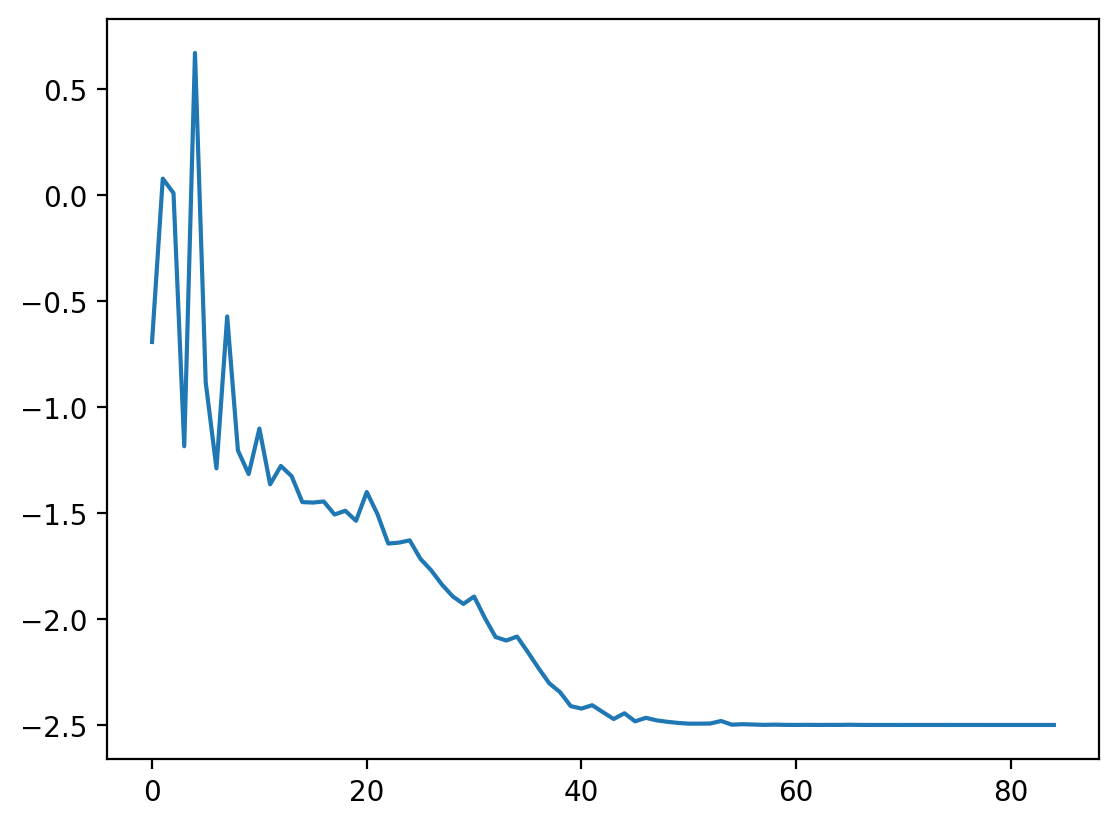

In [401]:
plt.plot(range(len(exp_val_list_real)), exp_val_list_real)

# Eigenvector

In [ ]:
sv = np.array(Statevector(Ansatz(nqubits,l, "RealAmplitudes")[0].bind_parameters(res.x))) 
sv

In [ ]:
Psi = eigenvectors[:,np.where(eigenvalues==min(eigenvalues))[0][0]]
Psi

In [ ]:
Psi = sv

In [391]:
eigenvalues

array([ 1.03077641+0.j, -0.25      +0.j, -1.03077641+0.j,  0.25      +0.j])

# Excited States

In [402]:
Qeigenstate = []
# Ceigenstate = []

Qeigenstate.append(Psi)
# Ceigenstate.append(eigenvectors[:,np.where(eigenvalues==min(eigenvalues))[0][0]])

Project = np.outer(Psi, Psi)
for i in range(3):
    
    H = H + 5*Project
    
    res = minimize(obj_fun, params, callback=CB, method="COBYLA", options={'tol': 1e-3,'maxiter':1000})
    print("Quantum Excited state ",i+1," is ",res.fun)

#     min_index = np.argmin(eigenvalues)
#     eigenvalues = np.delete(eigenvalues, min_index)
    
#     print("Classical Excited state ",i+1," is ",min(eigenvalues))
#     print("--------------")
    Psi = np.array(Statevector(Ansatz(nqubits,l, "RealAmplitudes")[0].bind_parameters(res.x))) 
    #Psi = eigenvectors[:,np.where(eigenvalues==min(eigenvalues))[0][0]]
    
    Qeigenstate.append(Psi)
    # Ceigenstate.append(eigenvectors[:,np.where(eigenvalues==min(eigenvalues))[0][0]])
    
    Project += np.outer(Psi, Psi)
    

Energy is: (-0.8387881439013607-2.0796916566881872e-16j)
------
Energy is: (-0.29396652633508763-1.0291425538798784e-16j)
------
Energy is: (-0.1325580982296211-3.573185505789131e-17j)
------
Energy is: (-0.9922334864313659+0j)
------
Energy is: (1.3132049161960575+7.146371011578262e-17j)
------
Energy is: (-0.8581543106983632-2.1010982056166178e-16j)
------
Energy is: (-0.8665709775421946-1.4078676533872219e-16j)
------
Energy is: (-0.7799767123924917-1.4078676533872219e-16j)
------
Energy is: (-0.8640465037888767-7.146371011578262e-17j)
------
Energy is: (-0.9864333413193629-7.146371011578262e-17j)
------
Energy is: (-0.9924410241913477-1.3864611044587913e-16j)
------
Energy is: (-0.9184483168697646-2.4370102072671e-16j)
------
Energy is: (-0.9882217529385897-2.1010982056166175e-16j)
------
Energy is: (-0.9962127576214168-6.932305522293956e-17j)
------
Energy is: (-0.9950584921311217+6.718240033009653e-17j)
------
Energy is: (-0.9843562790221371-2.1010982056166175e-16j)
------
Energy

In [394]:
exp_val_list_real

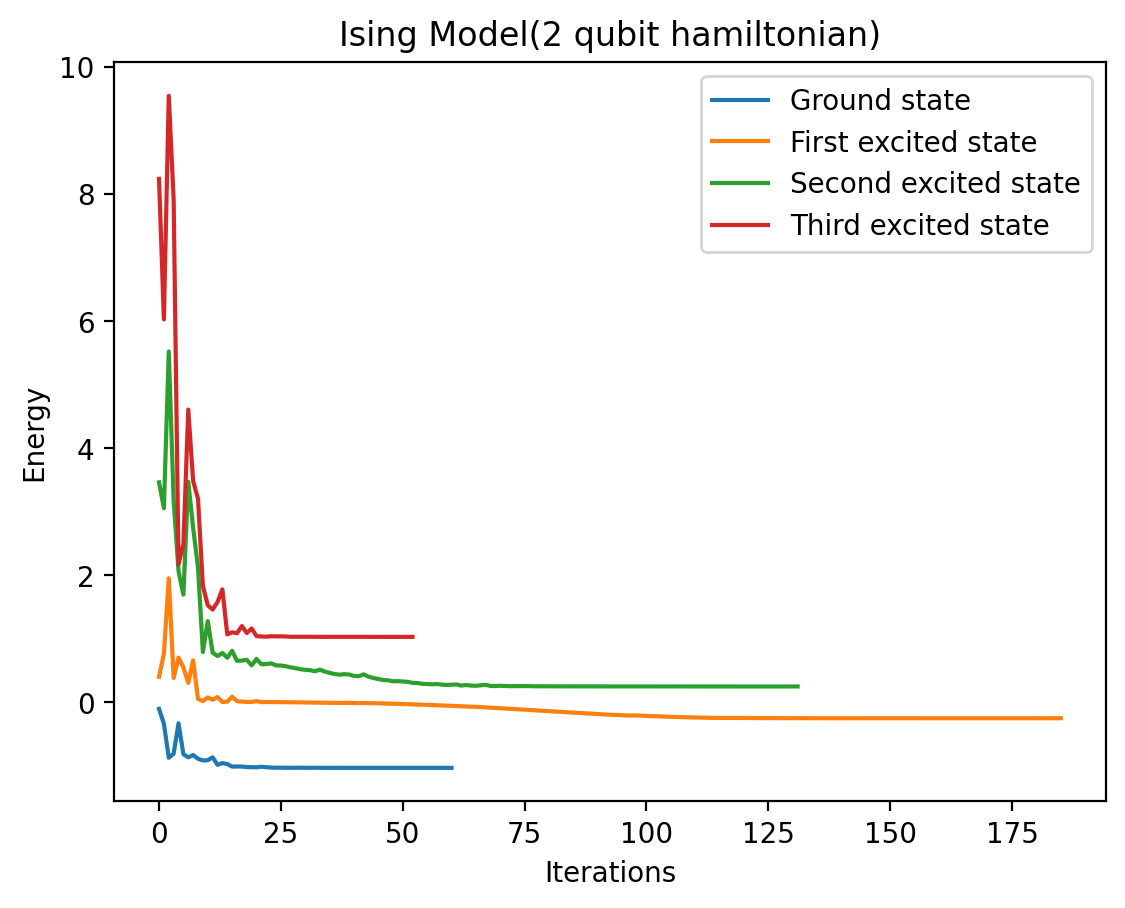

In [395]:
plt.plot(range(len(e0)),e0,label="Ground state")
plt.plot(range(len(e1)),e1,label="First excited state")
plt.plot(range(len(e2)),e2,label="Second excited state")
plt.plot(range(len(e3)),e3,label="Third excited state")

plt.title("Ising Model(2 qubit hamiltonian)")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.savefig('plot_ising.png', dpi=300)

In [373]:
plt.savefig('Heisnberg model.png', dpi= 1000)

<Figure size 640x480 with 0 Axes>

In [233]:
np.real(np.round(Ceigenstate[2],4)), np.real(np.round(Qeigenstate[2],4))

(array([-0.    ,  0.7071,  0.7071, -0.    ]),
 array([ 1.000e-04,  7.073e-01,  7.069e-01, -3.300e-03]))

In [236]:
Ceigenstate_ = np.real(Ceigenstate)
Qeigenstate_ = np.real(Qeigenstate)
print(Ceigenstate_[0])
print(Qeigenstate_[0])

[ 0.          0.70710678 -0.70710678  0.        ]
[-2.72742415e-04  7.07226687e-01 -7.06986682e-01 -4.13058591e-04]


In [237]:
np.dot(Qeigenstate[2], Ceigenstate[2])

(0.9999944217889737+0j)

# Transition Amplitudes (SWAP test)

In [241]:
from_state = 0
to_state = 1
qc = QuantumCircuit(2*nqubits + 1, 1)

qc.initialize(Qeigenstate[from_state], range(1,n+1))
qc.initialize(Qeigenstate[to_state], range(n+1, (2 * n)+1))

qc.h(0)  
for i in range(n):
    qc.cswap(0, i+1, i+1 + n) 
qc.h(0)

qc.measure(0, 0)

simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
job = execute(compiled_circuit, simulator, shots=1024)
result = job.result()

counts = result.get_counts()

# Calculate the probability of measuring |0> on the ancilla qubit
p_zero = counts.get('0', 0) / 1024
print("Probability of 0 ",from_state," to ",to_state," is ", p_zero)
print(np.sqrt(np.real(2 * p_zero - 1)))


Probability of 0  0  to  1  is  0.50390625
0.50390625
0.08838834764831845


If orthogonal then the probability that 0 is measured is 0.5 <br>
If the states are equal then the probability that 0 is measured is 1

In [ ]:
e0 = [-0.10235479047480339,
 -0.3350612909348626,
 -0.8718345045052088,
 -0.8078429784052185,
 -0.3300122720399502,
 -0.8163288803427071,
 -0.8644878966329583,
 -0.8286123250838235,
 -0.8885565484802201,
 -0.9149190357629232,
 -0.910893883374973,
 -0.8653006218820921,
 -0.9833779711100475,
 -0.9562211494920989,
 -0.9711884824234702,
 -1.0112776520504672,
 -1.0085984401631602,
 -1.0104915096310634,
 -1.018718202590551,
 -1.0202450840254782,
 -1.0215173991468807,
 -1.0134678236996004,
 -1.0204636353547363,
 -1.026613740998657,
 -1.029399161506822,
 -1.0281655556023268,
 -1.0297419786581115,
 -1.0297909792190765,
 -1.0296760794524837,
 -1.028989673246647,
 -1.029510042232212,
 -1.0302236670963896,
 -1.0295806268178456,
 -1.030028022715813,
 -1.030522133352671,
 -1.0306361306090703,
 -1.0297072303138202,
 -1.0306865855946017,
 -1.030447353781782,
 -1.030678756365805,
 -1.0306293443503967,
 -1.0305963841946113,
 -1.0307265935494645,
 -1.030726017900591,
 -1.0307029892121073,
 -1.0307630414211317,
 -1.0307378135986272,
 -1.030761155189816,
 -1.0307572804882439,
 -1.030767248200462,
 -1.030755903823173,
 -1.0307739615644291,
 -1.0307714841640476,
 -1.0307735290513778,
 -1.030772952483717,
 -1.0307751792027033,
 -1.0307745298977613,
 -1.0307739126806328,
 -1.0307745439289984,
 -1.0307758735196846,
 -1.0307758735196846]
e1 = [
 0.40313009096183544,
 0.7649165550328622,
 1.9528310907919868,
 0.3840785320464731,
 0.7039151153624214,
 0.5518442022050771,
 0.30623907889826124,
 0.6611134069960043,
 0.05371195170600036,
 0.02089298439728674,
 0.07755532925081299,
 0.041518062939898584,
 0.0828921198007186,
 0.006183295814738572,
 0.010404652990033528,
 0.08825921013899896,
 0.01962033461843038,
 0.011486289953286315,
 0.0064712835889995405,
 0.006682442706155171,
 0.01918970410883066,
 0.004183306346598327,
 0.00515675291438027,
 0.004861762216793603,
 0.003714029351964763,
 0.002660374259016402,
 0.0021000876506284006,
 0.0015610443772813179,
 0.000559303176909221,
 0.0002182066105136475,
 -0.001694716364474374,
 -0.0024815669531417913,
 -0.0037088446968414584,
 -0.00496467828298054,
 -0.006095937211201463,
 -0.007656847162088188,
 -0.008310304799108735,
 -0.009152780475246208,
 -0.008043127858440595,
 -0.0077668498742851436,
 -0.010545180557310786,
 -0.011967363850773564,
 -0.010227611590981033,
 -0.01176174642422326,
 -0.013782422575717743,
 -0.014619648668411098,
 -0.01705200833241454,
 -0.01900000216587782,
 -0.021134938877749386,
 -0.023188807359529533,
 -0.02577643498764024,
 -0.028341839411542686,
 -0.03115428614027538,
 -0.03391496720480833,
 -0.036656105884920374,
 -0.039166668688911874,
 -0.041755706074321386,
 -0.04502333307801226,
 -0.047624730968381226,
 -0.051278329177243114,
 -0.054725434283284496,
 -0.05821686020969151,
 -0.06145298300398311,
 -0.06487266481476932,
 -0.06799946206783962,
 -0.07020476576227631,
 -0.07503135453078534,
 -0.07940751472810949,
 -0.08371575977008273,
 -0.08820582877474982,
 -0.09266055047542116,
 -0.09715398002296854,
 -0.10166244454486124,
 -0.10618059378404571,
 -0.1107039152761723,
 -0.11523174633567486,
 -0.11975843707070628,
 -0.12428736256809099,
 -0.128807828292531,
 -0.13334460044909704,
 -0.13758673784864295,
 -0.1422442294150236,
 -0.1468164183265392,
 -0.15136090590953546,
 -0.1558708159187867,
 -0.16040108651461227,
 -0.16485445317771708,
 -0.16925346088805668,
 -0.17367429472318596,
 -0.17933427637091,
 -0.18472990163628128,
 -0.18844455496478257,
 -0.19271195034525776,
 -0.1968128425212264,
 -0.19787065412419738,
 -0.20219243967237222,
 -0.20592407909682445,
 -0.20599085711626733,
 -0.20651100599620562,
 -0.21034668298076314,
 -0.21405276206444301,
 -0.217222780976614,
 -0.21834453660569456,
 -0.22205623135288804,
 -0.22523528038376,
 -0.228159901020145,
 -0.22923386618662148,
 -0.23251754659360044,
 -0.2347868563524061,
 -0.23669325403706387,
 -0.23758600916165962,
 -0.2401897328477785,
 -0.24218013098439073,
 -0.24361139926039943,
 -0.24510328838495452,
 -0.24507717869037407,
 -0.24511582665738296,
 -0.24612023173705905,
 -0.24611198920135102,
 -0.2462868914711188,
 -0.2462130690533419,
 -0.245761962157749,
 -0.24707639001406498,
 -0.24759516923253846,
 -0.24796015209540856,
 -0.2478865309857058,
 -0.24792651922780234,
 -0.24840663108968047,
 -0.2487661271244416,
 -0.24904993050945934,
 -0.24895577932037838,
 -0.24913496605871444,
 -0.2493304723689815,
 -0.24896126650622868,
 -0.24934931928373466,
 -0.24938803850289654,
 -0.24943429000169923,
 -0.24950152186325775,
 -0.24961134496775747,
 -0.24965577173588038,
 -0.24969746508822,
 -0.24962769381194913,
 -0.2497555118617773,
 -0.2498116508119898,
 -0.2497710662687676,
 -0.24982690317858253,
 -0.24987621067445953,
 -0.2497317987475774,
 -0.24989098161767215,
 -0.24991269558078372,
 -0.24991508675455543,
 -0.24994220650661297,
 -0.24996043438336446,
 -0.24996200545020003,
 -0.24996471200730064,
 -0.24997135099174503,
 -0.24996538478510885,
 -0.2499468111618557,
 -0.24997959400083986,
 -0.2499807933324729,
 -0.2499819858101378,
 -0.249979845520826,
 -0.24998705129450371,
 -0.249987535395273,
 -0.24999100706446506,
 -0.24999136294797716,
 -0.24999153938328236,
 -0.24999374225639898,
 -0.2499948689393755,
 -0.24999244931111061,
 -0.2499950719951087,
 -0.2499941181981749,
 -0.2499962561985521,
 -0.24999742553351872,
 -0.24999703355004843,
 -0.24999827526326396,
 -0.24999851877985207,
 -0.2499980182868062,
 -0.24999899033239867,
 -0.24999775381410289,
 -0.24999864786150322,
 -0.24999965697385426,
 -0.24999917351617998,
 -0.2499994696451651,
 -0.24999927466346844,
 -0.24999927466346844]
e2 = [
 3.4620703618674327,
 3.056202333618326,
 5.521885148129686,
 3.176036394796527,
 2.0643982926868247,
 1.6956491208432973,
 3.4730291417364536,
 2.747822978128215,
 2.118159583693766,
 0.7932481361704251,
 1.277612001036031,
 0.7820400747141247,
 0.7288121400814412,
 0.7772424228369176,
 0.7014553589431702,
 0.8105778142583302,
 0.65252244670962,
 0.6578864771942754,
 0.6693827220714128,
 0.5819834903278609,
 0.6837039964222857,
 0.5993574648797508,
 0.6031341905895753,
 0.6135793123723312,
 0.5816897672666368,
 0.5796526801886506,
 0.5685888521304325,
 0.5511992237445353,
 0.5379532976728332,
 0.5213855207256064,
 0.5115543080678597,
 0.5063613868392494,
 0.48877646698654,
 0.5152518395401284,
 0.48401188541261386,
 0.4637488968409782,
 0.44515262259185184,
 0.4358212478933865,
 0.44368074529718116,
 0.43824164249016784,
 0.41611704590007137,
 0.41209438421625655,
 0.44121219107252707,
 0.40289018424546197,
 0.3833664454754744,
 0.3660028732812852,
 0.35142096843562465,
 0.3475174842134967,
 0.33151243568731936,
 0.33442398496383063,
 0.32767674267262814,
 0.3233051217101168,
 0.3075790021182745,
 0.30462068808339327,
 0.29223608767148734,
 0.2892794637173499,
 0.2846480950850505,
 0.28731146018489184,
 0.27890332128357676,
 0.27302579794243,
 0.27808135204991435,
 0.2817182110512897,
 0.26393645391953346,
 0.273715382830338,
 0.2636936942018939,
 0.261066645196943,
 0.26916340517641957,
 0.2753546182495348,
 0.25787778183372434,
 0.2567819081351057,
 0.2607489265354046,
 0.2571528821557403,
 0.2548664618641048,
 0.2559175490711907,
 0.25452554741529965,
 0.2567372448468128,
 0.2546264429389229,
 0.25336358396797265,
 0.2528495202559189,
 0.25273421956881426,
 0.25235103246012547,
 0.2526649108089074,
 0.25226872172486403,
 0.2518609996152612,
 0.25156487461683263,
 0.2517208160492497,
 0.2515782613122661,
 0.25138794043335877,
 0.25127748939445116,
 0.25149918175292774,
 0.25100843769481695,
 0.25108447096800734,
 0.2509322187826446,
 0.2508311390197786,
 0.25133967727078543,
 0.2506239626181701,
 0.2506159446050218,
 0.2506736007272188,
 0.25038233490116957,
 0.25039631881687874,
 0.2503683168007118,
 0.25042906206947824,
 0.25031049655055315,
 0.2502283885487475,
 0.2501930981776346,
 0.2501751059814672,
 0.2501230135268455,
 0.250115367265229,
 0.25007575027266626,
 0.25010987347367286,
 0.2501001830043119,
 0.2500635970570859,
 0.25007020559948256,
 0.2500885562991666,
 0.2500486133177715,
 0.25014421977951695,
 0.25002732952712825,
 0.25002809925147274,
 0.2500332695721956,
 0.2500194832555631,
 0.2500174048290298,
 0.25001733907270185,
 0.2500101232670635,
 0.2500063784467952,
 0.2500099677150973,
 0.25000648957991944,
 0.2500155525641561,
 0.250009336473499,
 0.2500080845159556,
 0.2500049275547267,
 0.2500078165849493,
 0.2500078165849493]
e3 = [
 8.239528898322867,
 6.027664242193742,
 9.545877610043943,
 7.918167041102294,
 2.172055754397172,
 2.4902739418056647,
 4.607797362896363,
 3.4843933922898644,
 3.2019655550751738,
 1.8318283336248533,
 1.5272311436292294,
 1.4600406875792464,
 1.57847608124036,
 1.7788137804721014,
 1.0693926921087251,
 1.1028439969602326,
 1.0887029421658871,
 1.2013584638367147,
 1.0907026745009811,
 1.1632063792683198,
 1.042412927439412,
 1.03703506471803,
 1.0337351972054192,
 1.0406026042120773,
 1.0379967759724678,
 1.039130077662539,
 1.0373572769965604,
 1.0315317420427164,
 1.0321633705069337,
 1.032453596919094,
 1.0328032345377713,
 1.0323827175979523,
 1.031376112280347,
 1.031258797127709,
 1.0310357903563228,
 1.0313551840453377,
 1.0308531731313983,
 1.0311933540959175,
 1.0308609497545373,
 1.030781450993418,
 1.0308721456371484,
 1.0310251399923902,
 1.0308427769497808,
 1.030789429735158,
 1.0308568871600206,
 1.030782828658073,
 1.0307706955736087,
 1.0307831021560288,
 1.0307842975958048,
 1.0307707594514315,
 1.0307712799988866,
 1.0307729838136714,
 1.0307729838136714]

In [ ]:
e0 = [-0.08701449034995937,
 -0.2484453483733407,
 -0.30248512349621726,
 -0.12539131250112867,
 -0.4689230061372866,
 -0.42686470662485215,
 -0.4929547868360886,
 -0.5361866105519244,
 -0.5527937754508586,
 -0.4567929950238548,
 -0.6007476427444877,
 -0.5291493668006164,
 -0.6807540526071741,
 -0.7601647297990698,
 -0.8289350928458045,
 -0.8782346843850951,
 -0.8266609264298874,
 -0.8757999008215362,
 -0.929603719101765,
 -0.9263947043898291,
 -0.9642146165524651,
 -0.9055399347195864,
 -0.9519585923189955,
 -0.9854397823195522,
 -0.9073305379953003,
 -0.9846513743514378,
 -0.9893618639123228,
 -0.9953071919433953,
 -0.9992065356107838,
 -0.9866631536699355,
 -0.9973670262814798,
 -0.9998676305826004,
 -0.9956193216473294,
 -0.9997412562165291,
 -0.9974798257958525,
 -0.9993082563306606,
 -0.998398512561808,
 -0.9997935225837435,
 -0.9998301170434519,
 -0.9999272048713086,
 -0.9998556893354271,
 -0.9998995900251136,
 -0.999913654629911,
 -0.9999331079657034,
 -0.999970179014184,
 -0.9999847682807099,
 -0.9999689840552166,
 -0.9999778872374216,
 -0.9999945999597286,
 -0.999997251947079,
 -0.999996351428005,
 -0.999996656827632,
 -0.9999955455397602,
 -0.9999964214120025,
 -0.9999966131963778,
 -0.9999981336742338,
 -0.999997413478096,
 -0.9999986238967742,
 -0.9999992797804536,
 -0.999999374786212,
 -0.999999374786212]
e1 = [      
 -0.06915002345349108,
 0.7344543564471746,
 -0.13489030363606014,
 -0.25822746704650157,
 -0.2377918722535862,
 0.022178665005415432,
 -0.27245571936687735,
 -0.2687162461569018,
 -0.3009585657536635,
 -0.26909055796151704,
 -0.2653788884719389,
 -0.22245021426269346,
 -0.37054557495888696,
 -0.4444230289980986,
 -0.46302852465954314,
 -0.39291393559112514,
 -0.4288760044537703,
 -0.46888089033447894,
 -0.465872099569388,
 -0.46649472723575713,
 -0.4831773865404422,
 -0.4497443939517336,
 -0.4867771072813699,
 -0.46609574716627655,
 -0.48061179308725127,
 -0.4837986121458331,
 -0.4869062661298714,
 -0.4859922822355277,
 -0.47464326282465175,
 -0.4933048127718346,
 -0.4933225631428102,
 -0.4876688486717718,
 -0.4949454365947207,
 -0.49444055986907415,
 -0.49296928228854753,
 -0.4950945392756333,
 -0.49616091753228775,
 -0.4974956828222298,
 -0.49833250264236884,
 -0.4979554310669848,
 -0.49836389768158956,
 -0.49597079648763265,
 -0.4983004710044088,
 -0.4983964545373026,
 -0.49828567532478957,
 -0.4982862749439579,
 -0.49795945034339895,
 -0.49875717475498105,
 -0.4982698870889791,
 -0.49861390886357243,
 -0.4987193064785593,
 -0.4985653855688713,
 -0.4988145818380224,
 -0.4989688792880508,
 -0.4988774092377414,
 -0.4990655024357784,
 -0.49909116350612115,
 -0.4990895856822675,
 -0.4991478229078018,
 -0.49923529742497086,
 -0.4993183116724121,
 -0.4993914740614641,
 -0.4994464067787178,
 -0.49949358936970534,
 -0.4995323172921103,
 -0.49959794898232884,
 -0.49965641294797436,
 -0.4996966897013093,
 -0.49974085072729557,
 -0.49977945967369775,
 -0.4998183463495305,
 -0.49985465614637237,
 -0.49985963462759986,
 -0.499864846326161,
 -0.49989483785894206,
 -0.49991812182596485,
 -0.4999284661180097,
 -0.4999447785479675,
 -0.49995379091859804,
 -0.49995319965677476,
 -0.49995346973046295,
 -0.4999345747242981,
 -0.49996428249038155,
 -0.4999659319840361,
 -0.49996113179326973,
 -0.49997463246999313,
 -0.499980067967199,
 -0.4999860931546042,
 -0.49999102219976643,
 -0.4999932991675827,
 -0.4999952858213577,
 -0.4999960931612014,
 -0.49999738311996883,
 -0.4999991425305592,
 -0.4999960200700952,
 -0.4999990821859841,
 -0.4999986767795568,
 -0.4999985081118943,
 -0.4999987919534627,
 -0.4999987919534627]
e2 = [
 1.0557492625637719,
 0.7118239432017057,
 2.166297286360474,
 1.1643686589464082,
 1.0113895059405305,
 0.5079548774885696,
 1.1665109148020343,
 0.685403374082717,
 0.3222094489446499,
 0.5572772735112494,
 0.6677648939107811,
 0.3911946536856015,
 0.1782104590627791,
 0.23604804746209557,
 0.16069445036538021,
 0.15215205937149812,
 0.3996360854154388,
 0.22634013721639273,
 0.06005063466100802,
 0.1828549983963636,
 0.06599469314317186,
 0.16198652071121267,
 0.11097313199308145,
 0.11746591645594673,
 0.1127983207473312,
 0.05157647330117798,
 0.047646842540838175,
 0.03596531856669205,
 0.019560452321351063,
 0.009877711885002971,
 0.012254072025326801,
 0.00839710563042162,
 0.011486809837223722,
 0.007385995977479687,
 0.01369549056608399,
 0.0066349227219361095,
 0.0029680228756060467,
 0.0011227472167595343,
 0.002552751518982155,
 0.0001556727573379657,
 0.00011937385855809168,
 0.0010389553472673896,
 0.001090275971947885,
 0.0005020716392587499,
 0.00027674468265048713,
 2.313711583279421e-05,
 0.00017140703678353297,
 1.4313948842326063e-05,
 5.7438645810425903e-05,
 7.044473654771455e-05,
 4.3631258938359174e-05,
 4.678014142756037e-05,
 3.916163625716784e-06,
 1.3021402706647756e-05,
 6.355620886799862e-06,
 4.679366973903143e-07,
 9.941224295983986e-07,
 1.0968653544773943e-05,
 3.0272363962247084e-06,
 -1.0336879634476048e-06,
 -4.2232991670498876e-07,
 -1.0275705186746364e-06,
 9.87741374136597e-07,
 9.87741374136597e-07]
e3=[ 
 5.966132169235666,
 5.0319644845190865,
 5.659324107686639,
 3.657930641753645,
 3.5220106139077823,
 2.6397515316605293,
 2.108021512733247,
 3.0805673372808275,
 2.03335889678037,
 1.5621018364238726,
 1.7383898397623554,
 1.58932516459911,
 1.7694785602681378,
 1.5174043870353644,
 1.6180090531788844,
 1.521842840885824,
 1.5409679841292927,
 1.5366857337378814,
 1.5034777196026126,
 1.5042127694295924,
 1.502411561168339,
 1.501601052751414,
 1.502434443868512,
 1.5019187644198273,
 1.5010285761238775,
 1.502082682086893,
 1.50050676799185,
 1.500653471908468,
 1.5006855679483206,
 1.5014595295279798,
 1.50043886160869,
 1.5004797835554102,
 1.5004743938826537,
 1.500123990145248,
 1.500251674972734,
 1.500137521576824,
 1.5001089594697703,
 1.5001013139940518,
 1.5001444229357388,
 1.5001791719702513,
 1.500014649157648,
 1.5000008366706739,
 1.5000209272973393,
 1.5000087277751026,
 1.500018256173151,
 1.5000382214098007,
 1.5000125920262692,
 1.5000022098326975,
 1.5000040482087789,
 1.4999999303169653,
 1.4999999303169653]